In [6]:
#coding=utf-8
import pandas as pd
import numpy as np
import os
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
import warnings
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation
import itertools
from sklearn import preprocessing
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from itertools import product

mpl.rcParams['font.sans-serif'] = ['simhei']
mpl.rcParams['font.serif'] = ['simhei']

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

warnings.filterwarnings('ignore')

In [7]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# 读数

In [8]:
# 读取训练数据
tmp = []
file_path = "./hy_round1_train_20200102"
file_train = os.listdir(file_path)

for file in file_train:
    tmp1 = pd.read_csv("{}/{}".format(file_path, file))
    tmp1 = tmp1.sort_values(by=['time'])
    tmp.append(tmp1)  
df_train = pd.concat(tmp, axis=0, ignore_index=True)
del tmp
df_train = df_train.sort_values(by=['渔船ID', 'time']).reset_index(drop=True)
df_train = df_train.rename(columns={"速度":"vec","方向":"dir"})
print("df_train is ready!")
    
# 读取测试数据
tmp = []
file_path = "./hy_round1_testB_20200221"
file_test = os.listdir(file_path)

for file in file_test:
    tmp1 = pd.read_csv("{}/{}".format(file_path, file))
    tmp1 = tmp1.sort_values(by=['time'])
    tmp.append(tmp1)
df_test = pd.concat(tmp, axis=0, ignore_index=True)
del tmp
df_test = df_test.sort_values(by=['渔船ID', 'time']).reset_index(drop=True)
df_test = df_test.rename(columns={"速度":"vec","方向":"dir"})
print("df_test is ready!")

df_train is ready!
df_test is ready!


# EDA

In [4]:
def update_points(num):
    '''
    更新数据点
    '''
    point_ani1.set_data(x[num], y1[num])
    point_ani2.set_data(x[num], y2[num])
    point_ani3.set_data(cor_x[num], cor_y[num])
    return point_ani1, point_ani2

<IPython.core.display.Javascript object>


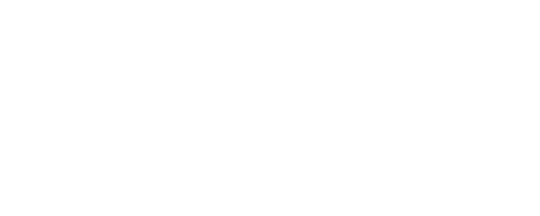

<IPython.core.display.Javascript object>


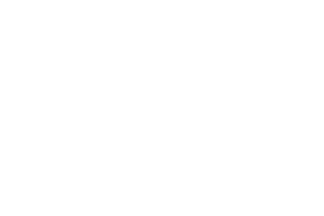

<IPython.core.display.Javascript object>


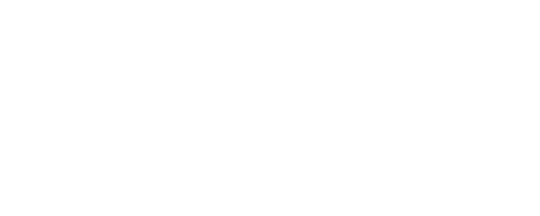

<IPython.core.display.Javascript object>


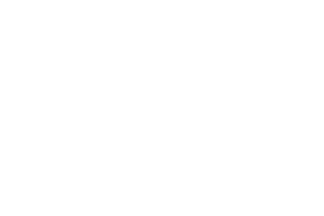

Traceback (most recent call last):
  File "/root/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/root/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [158]:
%matplotlib notebook

id = 4

t = df_train[df_train.渔船ID == id]
x = t.time.values
fig, ((ax1), (ax2)) = plt.subplots(2,1, sharex=True, figsize=(10, 4))

# vec 
y1 = t.vec.values
ax1.plot(x, y1)
ax1.set_title(t.type.unique()[0])
point_ani1, = ax1.plot(x[0], y1[0], 'ro')
plt.grid(ls='--')
ani = animation.FuncAnimation(fig, update_points, np.arange(0, len(x)), interval=50, blit=True)

# abs_diff_dir
y2 = t.dir.values
ax2.plot(x, y2)
point_ani2, = ax2.plot(x[0], y2[0], 'ro')
plt.grid(ls='--')
ani = animation.FuncAnimation(fig, update_points, np.arange(0, len(x)), interval=50, blit=True)

# cor_x, cor_y
cor_x = t['x'].values
cor_y = t['y'].values
fig = plt.figure(tight_layout=True)
plt.scatter(cor_x, cor_y)
point_ani3, = plt.plot(cor_x[0], cor_y[0], 'ro')
ani = animation.FuncAnimation(fig, update_points, np.arange(0, len(x)), interval=50, blit=True)
plt.grid(ls='--')
plt.show()

<IPython.core.display.Javascript object>


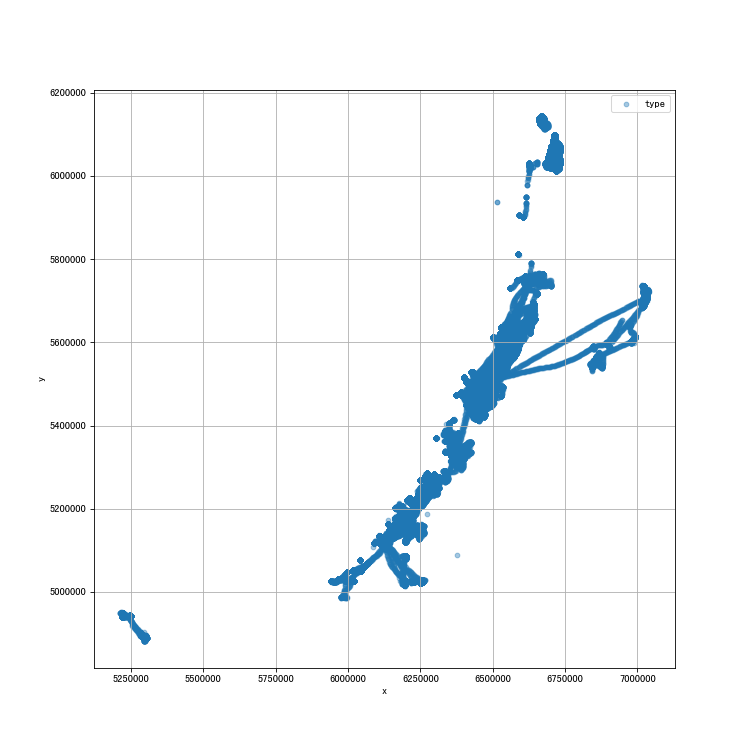

<IPython.core.display.Javascript object>


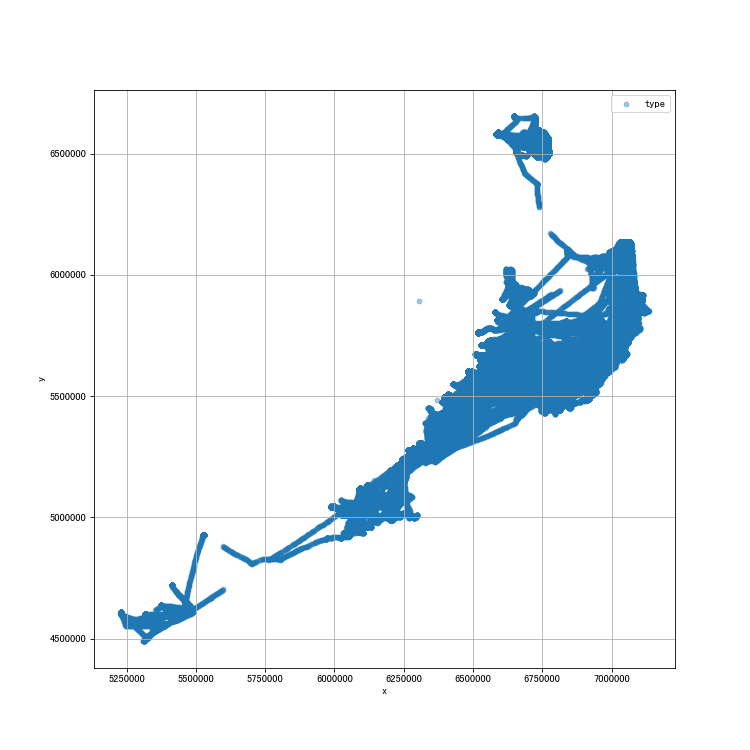

<IPython.core.display.Javascript object>


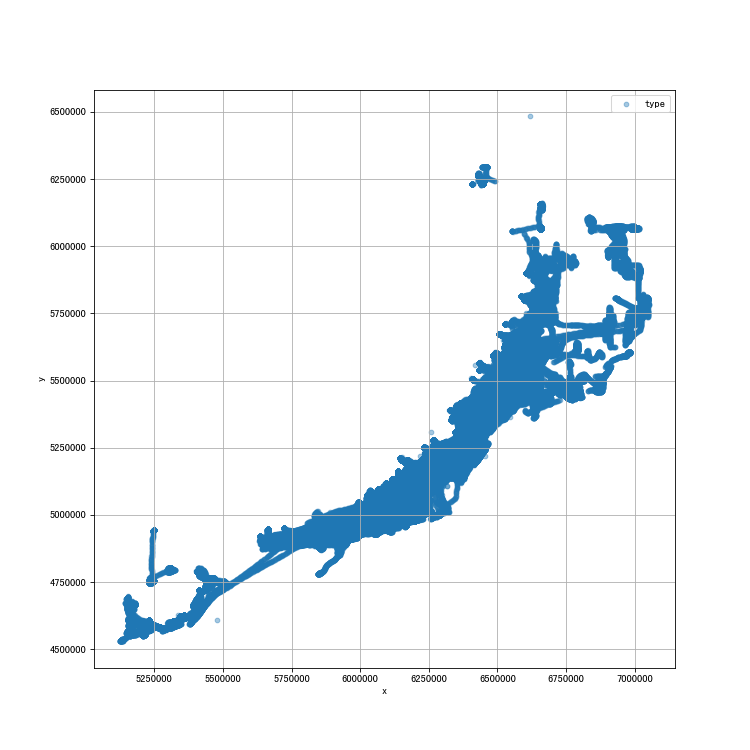

type
刺网    AxesSubplot(0.125,0.11;0.775x0.77)
围网    AxesSubplot(0.125,0.11;0.775x0.77)
拖网    AxesSubplot(0.125,0.11;0.775x0.77)
dtype: object

In [21]:
df_train.groupby('type').plot(kind="scatter",x="x",y="y",alpha=0.4,label='type', grid=True,figsize=(10,10))

In [49]:
train_label.plot(kind="scatter",x="x_mode",y="y_mode",
         alpha=1,
         c=train_label.type.map({"拖网":"blue","围网":"red","刺网":"green"}), 
         figsize=(15,13), 
         grid=True,
         s=4,
         xlim = (5100000,7200000), #21
         ylim = (4400000,6700000), #23
         xticks=np.arange(5000000,7100000,100000),
         yticks=np.arange(4000000,7600000,100000),
)

NameError: name 'train_label' is not defined

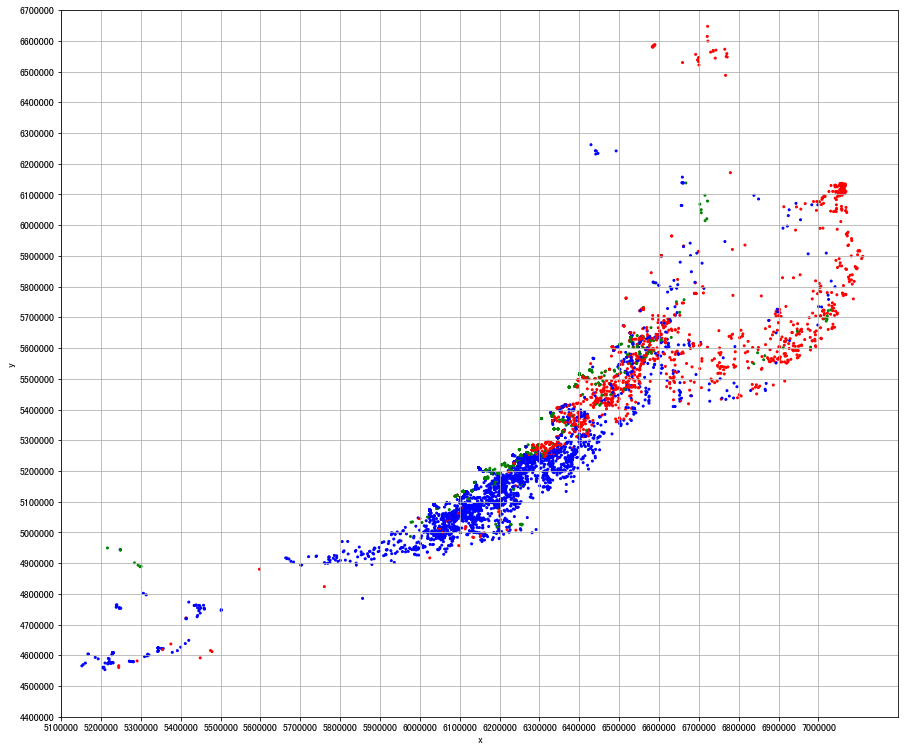

In [56]:
%matplotlib inline

train_label.plot(kind="scatter",x="x",y="y",
         alpha=1,
         c=train_label.type.map({"拖网":"blue","围网":"red","刺网":"green"}), 
         figsize=(15,13), 
         grid=True,
         s=4,
         xlim = (5100000,7200000), #21
         ylim = (4400000,6700000), #23
         xticks=np.arange(5000000,7100000,100000),
         yticks=np.arange(4000000,7600000,100000),
)

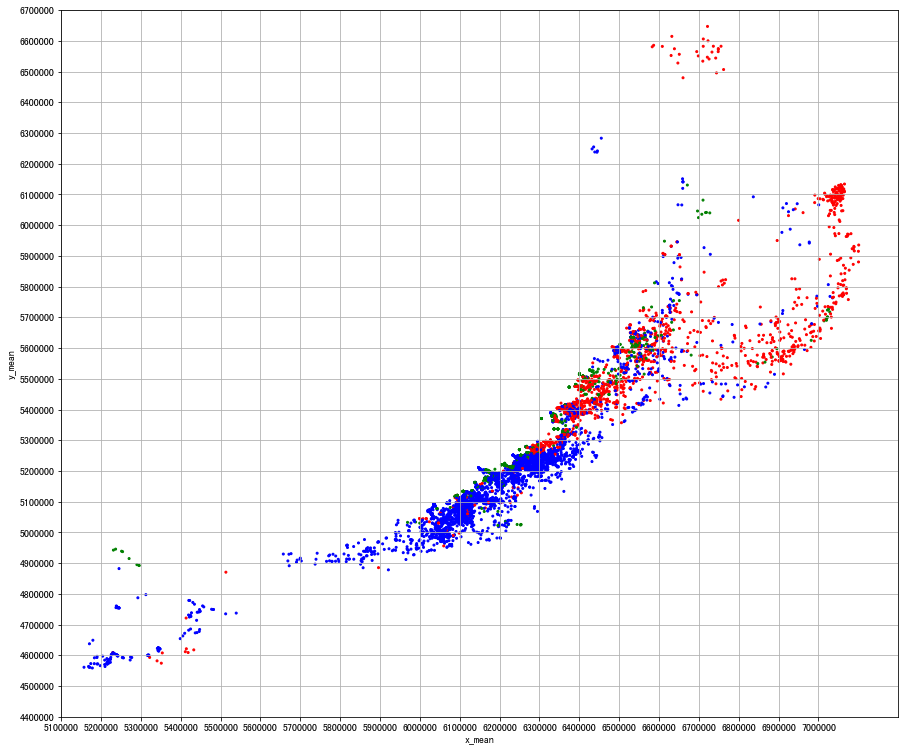

In [55]:
%matplotlib inline

train_label.plot(kind="scatter",x="x_mean",y="y_mean",
         alpha=1,
         c=train_label.type.map({"拖网":"blue","围网":"red","刺网":"green"}), 
         figsize=(15,13), 
         grid=True,
         s=4,
         xlim = (5100000,7200000), #21
         ylim = (4400000,6700000), #23
         xticks=np.arange(5000000,7100000,100000),
         yticks=np.arange(4000000,7600000,100000),
)

# 数据清洗

## 清楚异常坐标点

In [9]:
# 训练数据
bottom = (df_train.y < 4400000) | \
         ((df_train.x>5400000) & (df_train.y<4500000)) | \
         ((df_train.x>6000000) & (df_train.y<4850000)) 
df_train = df_train[~bottom]

above = ((df_train.x<5900000) & (df_train.y>5100000)) | \
        ((df_train.x>6800000) & (df_train.y>6300000)) 
df_train = df_train[~above]
df_train['vec'] = np.where(df_train['vec']>20, 20, df_train['vec'])

# 测试数据
bottom = (df_test.y < 4400000) | \
         ((df_test.x>5400000) & (df_test.y<4500000)) | \
         ((df_test.x>6000000) & (df_test.y<4850000)) 
df_test = df_test[~bottom]

above = ((df_test.x<5900000) & (df_test.y>5100000)) | \
        ((df_test.x>6800000) & (df_test.y>6300000)) 
df_test = df_test[~above]
df_test['vec'] = np.where(df_test['vec']>20, 20, df_test['vec'])

## 格式转化、归一化

In [10]:
def data_cleaning(df):
    # time_process
    df['date'] = df['time'].apply(lambda x: x.split()[0])
    df['date'] = df['date'].apply(lambda x: '2019-' + str(x[0:2]) + '-' + str(x[2:4]))
    df['hour'] = df['time'].apply(lambda x: x.split()[1])
    df['time'] = df['date'] + ' ' + df['hour']
    df['time'] = pd.to_datetime(df['time'])
    
    df = df.sort_values(by=['渔船ID', 'time']) # 根据时间排序
    
    # grouped by ID
    grouped = df.groupby('渔船ID')
    
    # count
    df["cnt"] = grouped["x"].transform("count")
    
    # different_x&y
    df["different_xy"] = grouped['x'].transform("nunique").astype("int32") # x&y的不同值
    
    # different_vec & dir
    df["different_vec"] = grouped['vec'].transform("nunique").astype("int32") # x&y的不同值   
    df["different_dir"] = grouped['dir'].transform("nunique").astype("int32") # x&y的不同值   
    
    # dietance & speed
    for col in ['x','y','time']:
        df['diff_' + col] = grouped[col].diff()
    df['diff_time'] = df['diff_time'].values/np.timedelta64(1,'h')
    df['ind_dist'] = np.sqrt(df['diff_x']**2  + df['diff_y']**2)
    df['ind_speed'] = df['ind_dist'] / df['diff_time']
    
    # velocity
    df['diff_vec']  = grouped['vec'].diff() # 速度变化
    df['vec_0_1'] = grouped['vec'].transform(lambda x:x/(x.max()))  # 归一化速度
    df['diff_vec_0_1']  = grouped['vec_0_1'].diff() # 归一化速度变化
    
    # direction
#     df['diff_dir'] = grouped['dir'].diff()
#     df['diff_dir'] = df['diff_dir'].apply(lambda x:(x-360)  if x>180 else  (x+360) if x<-180 else x) # 方向变化
#     df['abs_diff_dir'] = abs(df['diff_dir'])
    
    df['dir_process'] = df[['vec','dir']].apply(lambda x:0 if x['vec'] <= 0.32 else x['dir'],axis=1) # 速度为0的时候，方位也设为0
    df['diff_dir_process'] = grouped['dir_process'].diff()  
    df['diff_dir_process'] = df['diff_dir_process'].apply(lambda x:(x-360)  if x>180 else  (x+360) if x<-180 else x) # 方向变化
    df['abs_diff_dir_process'] = abs(df['diff_dir_process'])    
    
    # drop
    df = df.dropna()
    return df
    
df_train  = data_cleaning(df_train)
print("clear df_train finished!")
df_test   = data_cleaning(df_test)
print("clear df_test finished!")

clear df_train finished!
clear df_test finished!


## 备份

In [11]:
tmp_train_beifen = df_train.copy()
tmp_test_beifen  = df_test.copy()

In [52]:
df_train = tmp_train_beifen.copy()
df_test  = tmp_test_beifen.copy()

# 特征工程

In [12]:
train_label = df_train.drop_duplicates('渔船ID')
test_label  = df_test.drop_duplicates('渔船ID')

## 基础聚合特征

In [13]:
def get_abs_feature(df, train, target, aggs):
    t = abs(df[['渔船ID', target]])
    target_new = 'abs_'+target
    t = t.rename(columns={target:target_new})
    agg_dict = {}
    for ag in aggs:
        agg_dict[f'{target_new}_{ag}'] = ag
    t = t.groupby('渔船ID')[target_new].agg(agg_dict).reset_index()       
    train = pd.merge(train, t, on='渔船ID', how='left')
    return train

def group_feature(df, target, aggs):   
    agg_dict = {}
    for ag in aggs:
        agg_dict[f'{target}_{ag}'] = ag
    t = df.groupby('渔船ID')[target].agg(agg_dict).reset_index()
    return t

def extract_feature(df, train):
    # 坐标
    # 港口
    t = df.groupby('渔船ID')['x'].agg(lambda x: np.mean(pd.Series.mode(x))).reset_index()
    t = t.rename(columns={'x':'x_mode'})
    train = pd.merge(train, t, on='渔船ID', how='left')
    t = df.groupby('渔船ID')['y'].agg(lambda x: np.mean(pd.Series.mode(x))).reset_index()
    t = t.rename(columns={'y':'y_mode'})
    train = pd.merge(train, t, on='渔船ID', how='left')    
    
    t = group_feature(df,'x',['max','min','mean'])
    train = pd.merge(train, t, on='渔船ID', how='left')
    t = group_feature(df,'diff_x',['mean','std','skew','sum',])
    train = pd.merge(train, t, on='渔船ID', how='left')
    t = group_feature(df,'y',['max','min','mean'])
    train = pd.merge(train, t, on='渔船ID', how='left')
    t = group_feature(df,'diff_y',['mean','std','skew','sum'])
    train = pd.merge(train, t, on='渔船ID', how='left')
    t = group_feature(df,'ind_dist',['mean','std','skew','sum'])
    train = pd.merge(train, t, on='渔船ID', how='left')
    
    train['x_max_x_min'] = train['x_max'] - train['x_min']
    train['y_max_y_min'] = train['y_max'] - train['y_min']
    train['y_max_x_min'] = train['y_max'] - train['x_min']
    train['x_max_y_min'] = train['x_max'] - train['y_min']
    
    train['slope'] = train['y_max_y_min'] / np.where(train['x_max_x_min']==0, 0.001, train['x_max_x_min']) # 斜率
    train['area'] = train['x_max_x_min'] * train['y_max_y_min'] # 面积
    print("Coordinate feature finished!")
    
    # 速度
    vec_still = df[df['vec'] <= 0.32]
    vec_still = vec_still.groupby(['渔船ID'])['vec'].count().rename('v==still').reset_index()
    train = pd.merge(train, vec_still, on='渔船ID', how='left')
    train['v==still'] = train['v==still'].fillna(0)
    train['v==still/cnt'] = train['v==still'] / train['cnt']
#############################################################    
    # 去除原地不动的异常值
    # vec_drop_still
    df_drop_still = df[df.vec > 0.32]
    df_drop_still = df_drop_still.rename(columns={'vec':'vec_drop_still'})
    t = group_feature(df_drop_still,'vec_drop_still',['min','max','mean','std','skew','sum'])
    train = pd.merge(train, t, on='渔船ID', how='left')     
    # vec_0_1_drop_still
    df_drop_still = df[df.vec > 0.32]
    df_drop_still = df_drop_still.rename(columns={'vec_0_1':'vec_0_1_drop_still'})
    t = group_feature(df_drop_still,'vec_0_1_drop_still',['min','max','mean','std','skew','sum'])
    train = pd.merge(train, t, on='渔船ID', how='left')    
    # diff_vec_drop_still
    df_drop_still = df[df.vec > 0.32]
    df_drop_still['diff_vec']  = df_drop_still.groupby('渔船ID')['vec'].diff() # 速度变化
    df_drop_still = df_drop_still.dropna(subset =['diff_vec'])
    df_drop_still = df_drop_still.rename(columns={'diff_vec':'diff_vec_drop_still'})
    t = group_feature(df_drop_still,'diff_vec_drop_still',['min','max','mean','std','skew','sum'])
    train = pd.merge(train, t, on='渔船ID', how='left')   
    # diff_vec_0_1_drop_still
    df_drop_still = df[df.vec > 0.32]
    df_drop_still['diff_vec_0_1']  = df_drop_still.groupby('渔船ID')['vec_0_1'].diff() # 速度变化
    df_drop_still = df_drop_still.dropna(subset=['diff_vec_0_1'])
    df_drop_still = df_drop_still.rename(columns={'diff_vec_0_1':'diff_vec_0_1_drop_still'})
    t = group_feature(df_drop_still,'diff_vec_0_1_drop_still',['min','max','mean','std','skew','sum'])
    train = pd.merge(train, t, on='渔船ID', how='left')       
    # ind_speed_drop_still
    df_drop_still = df[df.vec > 0.32]
    df_drop_still = df_drop_still.rename(columns={'ind_speed':'ind_speed_drop_still'})
    t = group_feature(df_drop_still,'ind_speed_drop_still',['min','max','mean','std','skew','sum'])
    train = pd.merge(train, t, on='渔船ID', how='left') 
###############################################################
    # vec
    t = group_feature(df,'vec',['min','max','mean','std','skew','sum'])
    train = pd.merge(train, t, on='渔船ID', how='left')     
    # vec_0_1
    t = group_feature(df,'vec_0_1',['min','max','mean','std','skew','sum'])
    train = pd.merge(train, t, on='渔船ID', how='left')    
    # diff_vec
    t = group_feature(df,'diff_vec',['min','max','mean','std','skew','sum'])
    train = pd.merge(train, t, on='渔船ID', how='left')   
    # diff_vec_0_1
    t = group_feature(df,'diff_vec_0_1',['min','max','mean','std','skew','sum'])
    train = pd.merge(train, t, on='渔船ID', how='left')       
    # ind_speed
    t = group_feature(df,'ind_speed',['min','max','mean','std','skew','sum'])
    train = pd.merge(train, t, on='渔船ID', how='left')
################################################################
    train = get_abs_feature(df, train,'diff_vec', ['mean', 'sum'])
    train = get_abs_feature(df, train,'diff_vec_0_1', ['mean', 'sum'])
    print("velocity feature finished!")

    # 方向
#########################################################################
    # dir_process_drop_still
    df_drop_still = df[df.vec > 0.32]
    df_drop_still = df_drop_still.rename(columns={'dir_process':'dir_process_drop_still'})
    t = group_feature(df_drop_still,'dir_process_drop_still',['max','mean','std','skew','sum'])
    train = pd.merge(train, t, on='渔船ID', how='left')  
    # diff_dir_process_drop_still
    df_drop_still = df[df.vec > 0.32]
    df_drop_still['diff_dir_process']  = df_drop_still.groupby('渔船ID')['dir_process'].diff() # 速度变化
    df_drop_still['diff_dir_process'] = df_drop_still['diff_dir_process'].apply(lambda x:(x-360)  if x>180 else  (x+360) if x<-180 else x) # 方向变化
    df_drop_still = df_drop_still.dropna(subset=['diff_dir_process'])
    df_drop_still = df_drop_still.rename(columns={'diff_dir_process':'diff_dir_process_drop_still'})
    t = group_feature(df_drop_still,'diff_dir_process_drop_still',['max','mean','std','skew','sum'])
    train = pd.merge(train, t, on='渔船ID', how='left')   
##########################################################################
    # dir_process
    t = group_feature(df,'dir_process',['max','mean','std','skew','sum'])
    train = pd.merge(train, t, on='渔船ID', how='left')  
    # diff_dir_process
    t = group_feature(df,'diff_dir_process',['max','mean','std','skew','sum'])
    train = pd.merge(train, t, on='渔船ID', how='left')   
###########################################################################
    train = get_abs_feature(df,train,'diff_dir_process', ['mean', 'sum'])
    print("direction feature finished!")
    
    # 时间特征
    max_time = df.groupby(['渔船ID'])['time'].max().rename('max_time').reset_index()
    min_time  = df.groupby(['渔船ID'])['time'].min().rename('min_time').reset_index()
    train['during'] = (max_time['max_time'] - min_time['min_time']).values/np.timedelta64(1, 'h') # during   
    
    t = df.groupby('渔船ID')['time'].agg({'time_max_minux_min':lambda x:np.max(x)-np.min(x)}).reset_index() # 时间间隔
    train = pd.merge(train, t, on='渔船ID', how='left')
    print("time feature finished!")
    
    # 其它特征
    train["different_xy/cnt"] = train["different_xy"] / train["cnt"]
    return train

print("开始提取训练集特征")
train_label = extract_feature(df_train,  train_label)
print("开始提取测试集特征")
test_label  = extract_feature(df_test,   test_label)

开始提取训练集特征
Coordinate feature finished!
velocity feature finished!
direction feature finished!
time feature finished!
开始提取测试集特征
Coordinate feature finished!
velocity feature finished!
direction feature finished!
time feature finished!


## xy 均值编码

In [14]:
class MeanEncoder:
    def __init__(self, categorical_features, n_splits=5, target_type='classification', prior_weight_func=None):
        """
        :param categorical_features: list of str, the name of the categorical columns to encode

        :param n_splits: the number of splits used in mean encoding

        :param target_type: str, 'regression' or 'classification'

        :param prior_weight_func:
        a function that takes in the number of observations, and outputs prior weight
        when a dict is passed, the default exponential decay function will be used:
        k: the number of observations needed for the posterior to be weighted equally as the prior
        f: larger f --> smaller slope
        """

        self.categorical_features = categorical_features
        self.n_splits = n_splits
        self.learned_stats = {}

        if target_type == 'classification':
            self.target_type = target_type
            self.target_values = []
        else:
            self.target_type = 'regression'
            self.target_values = None

        if isinstance(prior_weight_func, dict):
            self.prior_weight_func = eval('lambda x: 1 / (1 + np.exp((x - k) / f))', dict(prior_weight_func, np=np))
        elif callable(prior_weight_func):
            self.prior_weight_func = prior_weight_func
        else:
            self.prior_weight_func = lambda x: 1 / (1 + np.exp((x - 2) / 1))

    @staticmethod
    def mean_encode_subroutine(X_train, y_train, X_test, variable, target, prior_weight_func):
        X_train = X_train[[variable]].copy()
        X_test = X_test[[variable]].copy()

        if target is not None:
            nf_name = '{}_pred_{}'.format(variable, target)
            X_train['pred_temp'] = (y_train == target).astype(int)  # classification
        else:
            nf_name = '{}_pred'.format(variable)
            X_train['pred_temp'] = y_train  # regression
        prior = X_train['pred_temp'].mean()

        col_avg_y = X_train.groupby(by=variable, axis=0)['pred_temp'].agg({'mean': 'mean', 'beta': 'size'})
        col_avg_y['beta'] = prior_weight_func(col_avg_y['beta'])
        col_avg_y[nf_name] = col_avg_y['beta'] * prior + (1 - col_avg_y['beta']) * col_avg_y['mean']
        col_avg_y.drop(['beta', 'mean'], axis=1, inplace=True)

        nf_train = X_train.join(col_avg_y, on=variable)[nf_name].values
        nf_test = X_test.join(col_avg_y, on=variable).fillna(prior, inplace=False)[nf_name].values

        return nf_train, nf_test, prior, col_avg_y

    def fit_transform(self, X, y):
        """
        :param X: pandas DataFrame, n_samples * n_features
        :param y: pandas Series or numpy array, n_samples
        :return X_new: the transformed pandas DataFrame containing mean-encoded categorical features
        """
        X_new = X.copy()
        if self.target_type == 'classification':
            skf = StratifiedKFold(self.n_splits)
        else:
            skf = KFold(self.n_splits)

        if self.target_type == 'classification':
            self.target_values = sorted(set(y))
            self.learned_stats = {'{}_pred_{}'.format(variable, target): [] for variable, target in
                                  product(self.categorical_features, self.target_values)}
            for variable, target in product(self.categorical_features, self.target_values):
                nf_name = '{}_pred_{}'.format(variable, target)
                X_new.loc[:, nf_name] = np.nan
                for large_ind, small_ind in skf.split(y, y):
                    nf_large, nf_small, prior, col_avg_y = MeanEncoder.mean_encode_subroutine(
                        X_new.iloc[large_ind], y.iloc[large_ind], X_new.iloc[small_ind], variable, target, self.prior_weight_func)
                    X_new.iloc[small_ind, -1] = nf_small
                    self.learned_stats[nf_name].append((prior, col_avg_y))
        else:
            self.learned_stats = {'{}_pred'.format(variable): [] for variable in self.categorical_features}
            for variable in self.categorical_features:
                nf_name = '{}_pred'.format(variable)
                X_new.loc[:, nf_name] = np.nan
                for large_ind, small_ind in skf.split(y, y):
                    nf_large, nf_small, prior, col_avg_y = MeanEncoder.mean_encode_subroutine(
                        X_new.iloc[large_ind], y.iloc[large_ind], X_new.iloc[small_ind], variable, None, self.prior_weight_func)
                    X_new.iloc[small_ind, -1] = nf_small
                    self.learned_stats[nf_name].append((prior, col_avg_y))
        return X_new

    def transform(self, X):
        """
        :param X: pandas DataFrame, n_samples * n_features
        :return X_new: the transformed pandas DataFrame containing mean-encoded categorical features
        """
        X_new = X.copy()

        if self.target_type == 'classification':
            for variable, target in product(self.categorical_features, self.target_values):
                nf_name = '{}_pred_{}'.format(variable, target)
                X_new[nf_name] = 0
                for prior, col_avg_y in self.learned_stats[nf_name]:
                    X_new[nf_name] += X_new[[variable]].join(col_avg_y, on=variable).fillna(prior, inplace=False)[
                        nf_name]
                X_new[nf_name] /= self.n_splits
        else:
            for variable in self.categorical_features:
                nf_name = '{}_pred'.format(variable)
                X_new[nf_name] = 0
                for prior, col_avg_y in self.learned_stats[nf_name]:
                    X_new[nf_name] += X_new[[variable]].join(col_avg_y, on=variable).fillna(prior, inplace=False)[
                        nf_name]
                X_new[nf_name] /= self.n_splits

        return X_new

In [15]:
def get_cross_feature(train, cross_feature, bins):
    for col1, col2 in itertools.combinations(cross_feature, 2):
        t1 = pd.cut(train[col1], bins=bins, labels=False)
        t2 = pd.cut(train[col2], bins=bins, labels=False)
        new_col_name = '_'.join([col1,col2])
        new_values = t1.map(str) + '_' + t2.map(str) 
        encoder = preprocessing.LabelEncoder()
        t = encoder.fit_transform(new_values)
        train[new_col_name] = t
        train[new_col_name] = train[new_col_name].astype('category')
    return train

In [16]:
t = pd.concat([train_label, test_label], axis=0)
t = get_cross_feature(t, ['x_mode', 'y_mode'], 20)
t = get_cross_feature(t, ['x_mean', 'y_mean'], 20)
train_label = t[~t.type.isnull()]
test_label = t[t.type.isnull()]

# Encoder
meanencoder = MeanEncoder(['x_mode_y_mode', 'x_mean_y_mean'], n_splits=10)
# train 
t = meanencoder.fit_transform(train_label[['x_mode_y_mode','x_mean_y_mean']].astype('str'),\
                              train_label['type'].map({'拖网':1, '围网':2, '刺网':3}))
t.drop(columns=['x_mode_y_mode', 'x_mean_y_mean'], inplace=True)
train_label = pd.concat([train_label, t], axis=1)
# test 
t = meanencoder.transform(test_label[['x_mode_y_mode','x_mean_y_mean']].astype('str'))
t.drop(columns=['x_mode_y_mode', 'x_mean_y_mean'], inplace=True)
test_label  = pd.concat([test_label, t], axis=1)

## vec分箱和桶分析

In [17]:
def get_feature_bin_quanlity(df, train, bins):
    def get_bin_ana(group): #输入一个pandas的group对象
        tmp = pd.cut(group['vec'], bins, labels=False)        
        tmp = tmp.value_counts(normalize=True)
        tmp_1 = pd.DataFrame([], index=range(0,bins))
        tmp = pd.concat([tmp_1, tmp], axis=1).fillna(0).T
        tmp['cut_vec_sum'] = (tmp * range(bins)).sum(axis=1)
        tmp['cut_vec_skew'] = tmp[range(bins)].skew(axis=1)
        tmp['cut_vec_kurt'] = tmp[range(bins)].kurt(axis=1)
        return tmp
    
    # 去除原地不动的异常值
    df_drop_still = df[df.vec > 0.32]
    grouped = df_drop_still.groupby("渔船ID")
    df_vec_bin = grouped.apply(get_bin_ana)
    df_vec_bin = df_vec_bin.reset_index()
    train  = pd.merge(train, df_vec_bin, on='渔船ID', how='left')
    return train,  list(df_vec_bin.columns)

train_label, feature_bin_quanlity  = get_feature_bin_quanlity(df_train, train_label, 10)
print('train finished!')
test_label,  feature_bin_quanlity  = get_feature_bin_quanlity(df_test, test_label, 10)
print('test finished!')
print(feature_bin_quanlity)

train finished!
test finished!
['渔船ID', 'level_1', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'cut_vec_sum', 'cut_vec_skew', 'cut_vec_kurt']


## 强特分箱

In [18]:
def get_bin_features(train, features_list, bins):
    for each in features_list:
        t = pd.cut(train[each], bins=bins, labels=False)
        t = t.rename(columns={each:each+'_bins'})
        train[each+'_bins'] = t
    return train[~train.type.isnull()], train[train.type.isnull()]

In [19]:
t = pd.concat([train_label, test_label], axis=0)
train_label, test_label  = get_bin_features(t,   
                                            [
                                                'x_min', 'y_min',
                                                'x_max', 'y_max',
                                                'x_mean', 'y_mean',
                                                'x_mode','y_mode',
                                                'y_max_x_min', 'x_max_y_min'
                                                  ], bins=100)

## 速度&角度变化(相关系数、协方差)

In [29]:
def get_feature_corr(df, train, fea_list):
    def cal_corr(grouped):
        corr = grouped[fea_list[0]].corr(grouped[fea_list[1]])
    #     corr = grouped[fea_list[0]]
        return corr
    t = df.groupby('渔船ID').apply(cal_corr).rename('corr_'+fea_list[0]+'&'+fea_list[1]).reset_index()
    train = pd.merge(train, t, on='渔船ID', how='left')
    return train

def get_feature_cov(df, train, fea_list):
    def cal_cov(grouped):
        cov = grouped[fea_list[0]].cov(grouped[fea_list[1]])
    #     corr = grouped[fea_list[0]]
        return cov
    t = df.groupby('渔船ID').apply(cal_cov).rename('cov_'+fea_list[0]+'&'+fea_list[1]).reset_index()
    train = pd.merge(train, t, on='渔船ID', how='left')
    return train

# 去除原地不动的异常值
df_drop_still = df_train[df_train.vec > 0.32]
train_label = get_feature_corr(df_drop_still, train_label, ['diff_vec', 'abs_diff_dir_process'])
train_label = get_feature_corr(df_drop_still, train_label, ['diff_vec_0_1', 'abs_diff_dir_process'])
train_label = get_feature_cov(df_drop_still, train_label, ['diff_vec', 'abs_diff_dir_process'])
train_label = get_feature_cov(df_drop_still, train_label, ['diff_vec_0_1', 'abs_diff_dir_process'])
print('train finished!')

# 去除原地不动的异常值
df_drop_still = df_test[df_test.vec > 0.32]
test_label = get_feature_corr(df_drop_still, test_label, ['diff_vec', 'abs_diff_dir_process'])
test_label = get_feature_corr(df_drop_still, test_label, ['diff_vec_0_1', 'abs_diff_dir_process'])
test_label = get_feature_cov(df_drop_still, test_label, ['diff_vec', 'abs_diff_dir_process'])
test_label = get_feature_cov(df_drop_still, test_label, ['diff_vec_0_1', 'abs_diff_dir_process'])
print('test finished!')

#
feature_corr_cov = [each for each in list(train_label.columns) if ('corr' in str(each)) | ('cov' in str(each))]
print(feature_corr_cov)

print('fillna')
train_label[feature_corr_cov] = train_label[feature_corr_cov].fillna(0)
test_label[feature_corr_cov] = test_label[feature_corr_cov].fillna(0)

train finished!
test finished!
['corr_diff_vec&abs_diff_dir_process', 'corr_diff_vec_0_1&abs_diff_dir_process', 'cov_diff_vec&abs_diff_dir_process', 'cov_diff_vec_0_1&abs_diff_dir_process']
fillna


## 分类后计算到每类平均值的距离

In [24]:
t = pd.DataFrame()
t['cate_1_x_dist'] = train_label['x_mean'] - 6.186947e+06
t['cate_1_y_dist'] = train_label['y_mean'] - 5.176123e+06
train_label['cate_1_xy_dist'] = np.sqrt(t['cate_1_x_dist']**2  + t['cate_1_y_dist']**2)
t['cate_2_x_dist'] = train_label['x_mean'] - 6.518419e+06
t['cate_2_y_dist'] = train_label['y_mean'] - 5.500653e+06
train_label['cate_2_xy_dist'] = np.sqrt(t['cate_2_x_dist']**2  + t['cate_2_y_dist']**2)
t['cate_3_x_dist'] = train_label['x_mean'] - 6.279078e+06
t['cate_3_y_dist'] = train_label['y_mean'] - 5.312256e+06
train_label['cate_3_xy_dist'] = np.sqrt(t['cate_3_x_dist']**2  + t['cate_3_y_dist']**2)
print('train finished!')

t = pd.DataFrame()
t['cate_1_x_dist'] = test_label['x_mean'] - 6.186947e+06
t['cate_1_y_dist'] = test_label['y_mean'] - 5.176123e+06
test_label['cate_1_xy_dist'] = np.sqrt(t['cate_1_x_dist']**2  + t['cate_1_y_dist']**2)
t['cate_2_x_dist'] = test_label['x_mean'] - 6.518419e+06
t['cate_2_y_dist'] = test_label['y_mean'] - 5.500653e+06
test_label['cate_2_xy_dist'] = np.sqrt(t['cate_2_x_dist']**2  + t['cate_2_y_dist']**2)
t['cate_3_x_dist'] = test_label['x_mean'] - 6.279078e+06
t['cate_3_y_dist'] = test_label['y_mean'] - 5.312256e+06
test_label['cate_3_xy_dist'] = np.sqrt(t['cate_3_x_dist']**2  + t['cate_3_y_dist']**2)
print('test finished!')

feature_cate_dist = [each for each in list(train_label.columns) if 'cate_' in str(each)]
print(feature_cate_dist)

train finished!
test finished!
['cate_1_xy_dist', 'cate_2_xy_dist', 'cate_3_xy_dist']


# 模型训练

## Seaborn

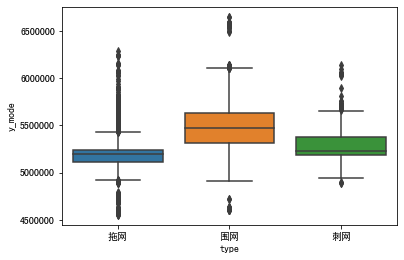

In [16]:
import seaborn as sns

sns.boxplot(x = train_label.type, y = train_label.y_mode)
plt.show()

## 特征筛选

In [30]:
features = [each for each in train_label.columns if each not in [
    '渔船ID', 'x','y','vec','dir','time','type', 'during',
    'date','hour','weekday',
    'diff_x','diff_y', 'diff_time_x', 'ind_dist', 'ind_speed','vec_0_1','diff_vec','diff_vec_0_1',
    'dir_process','diff_dir_process','abs_diff_dir_process',
    'diff_time','time_max_minux_min','diff_time_x','level_1',
    'vec_0_1_max','during_day', 'hour_nunique',
    'distance_land',
    'slope_od',
#     'x_min', 'y_min',
#     'x_max', 'y_max',
#     'x_mean', 'y_mean',
#     'x_mode','y_mode',
#     'y_max_x_min', 'x_max_y_min',
] ]
target = 'type'
print(features)

['abs_diff_dir_process_mean', 'abs_diff_dir_process_sum', 'abs_diff_vec_0_1_mean', 'abs_diff_vec_0_1_sum', 'abs_diff_vec_mean', 'abs_diff_vec_sum', 'area', 'cnt', 'diff_dir_process_drop_still_max', 'diff_dir_process_drop_still_mean', 'diff_dir_process_drop_still_skew', 'diff_dir_process_drop_still_std', 'diff_dir_process_drop_still_sum', 'diff_dir_process_max', 'diff_dir_process_mean', 'diff_dir_process_skew', 'diff_dir_process_std', 'diff_dir_process_sum', 'diff_vec_0_1_drop_still_max', 'diff_vec_0_1_drop_still_mean', 'diff_vec_0_1_drop_still_min', 'diff_vec_0_1_drop_still_skew', 'diff_vec_0_1_drop_still_std', 'diff_vec_0_1_drop_still_sum', 'diff_vec_0_1_max', 'diff_vec_0_1_mean', 'diff_vec_0_1_min', 'diff_vec_0_1_skew', 'diff_vec_0_1_std', 'diff_vec_0_1_sum', 'diff_vec_drop_still_max', 'diff_vec_drop_still_mean', 'diff_vec_drop_still_min', 'diff_vec_drop_still_skew', 'diff_vec_drop_still_std', 'diff_vec_drop_still_sum', 'diff_vec_max', 'diff_vec_mean', 'diff_vec_min', 'diff_vec_skew'

## lightgbm

In [21]:
def f1_macro(labels,preds):
    preds=np.argmax(preds.reshape(3,-1),axis=0)
    score=f1_score(y_true=labels,y_pred=preds,average='macro')
    return 'f1_macro',score,True

In [39]:
from collections import  Counter

models =[]
pred_test_offline = [] #线下测试集
pred_test_online = [] #线上测试集、
fea_importances = pd.Series(range(len(features)), index=features)

# t = train_label[~train_label["渔船ID"].isin(id_different_x_lt_20)].copy()
t = train_label.copy()
# t_train,t_test_offline = train_test_split(t, test_size=0.2,stratify=t['type'], shuffle=True) # 分层抽样
# t_train,t_test_offline = train_test_split(t, test_size=0.22, stratify=t['type'], shuffle=True) # 随机抽样


X = train_label[features].copy()

y = train_label[target]
# X_test_offline = t_test_offline[features].copy()
# y_test_offline = t_test_offline[target]
X_test_online = test_label[features].copy()

print('训练集大小')
print(X.shape)
print(y.shape)
# print('线下测试集大小')
# print(X_test_offline.shape)
print('线上测试集大小')
print(X_test_online.shape)

fold = StratifiedKFold(n_splits=10, shuffle=True)
for index, (train_idx, val_idx) in enumerate(fold.split(X, y)):
    train_set_x = X.iloc[train_idx]
    train_set_y = y.iloc[train_idx]
    val_set_x = X.iloc[val_idx]
    val_set_y = y.iloc[val_idx]
    
    model = lgb.LGBMClassifier(
            num_leaves =  30,
            objective='multiclass',
#             reg_alpha=0.1,
#             reg_lambeda=0.1,
#             max_depth = 6,
            learning_rate = 0.1,
            n_estimators = 1000,
            min_child_samples = 40,
            subsample = 0.9,
            colsample_bytree = 0.5,
            random_state = 44,
            silent = False,
            class_weight = 'balanced',
            )
    print("--------------------------------------------------------------------------------------------------------------------------------")
    model = model.fit(train_set_x, train_set_y,  
                                 eval_set=[(val_set_x, val_set_y)], 
                                 eval_metric=f1_macro, 
                                 early_stopping_rounds=100, 
                                 verbose=100) 
    models.append(model)
    fea_importances += model. feature_importances_

    val_pred = model.predict(X.iloc[val_idx])    
    
    c = Counter(val_pred)
    c = dict(c)
    c = pd.DataFrame(c, columns=["拖网","围网","刺网"], index=['pre_cnt']).T
    c['pre_per'] = c['pre_cnt'] / len(val_pred)
    c['real'] = val_set_y.value_counts()
    c['real_per'] = val_set_y.value_counts(normalize=True)
    print('\n',c)
    
    print('\n',"验证集")
    print(index, 'precision_score', metrics.precision_score(val_set_y, val_pred, average=None,labels=['拖网','围网','刺网']))
    print(index, 'recall_score', metrics.recall_score(val_set_y, val_pred, average=None,labels=['拖网','围网','刺网']))
    print(index, '每个类的评价指标', metrics.f1_score(val_set_y, val_pred, average=None,labels=['拖网','围网','刺网']))    
    print(index, '最终评价指标', metrics.f1_score(val_set_y, val_pred, average='macro',labels=['拖网','围网','刺网']))
    
#     print('\n','线下测试集')
#     print(index, 'precision_score', metrics.precision_score(model.predict(X_test_offline), y_test_offline, average=None,labels=['拖网','围网','刺网']))
#     print(index, 'recall_score', metrics.recall_score(model.predict(X_test_offline), y_test_offline, average=None,labels=['拖网','围网','刺网']))
#     print(index, '每个类的评价指标', metrics.f1_score(model.predict(X_test_offline), y_test_offline, average=None,labels=['拖网','围网','刺网']))    
#     print(index, '最终评价指标', metrics.f1_score(model.predict(X_test_offline), y_test_offline, average='macro',labels=['拖网','围网','刺网']), '\n')
#     pred_test_offline.append(model.predict(X_test_offline))
    
    print('\n','线上测试集')
    result = pd.Series(model.predict(X_test_online))
    print("2000个样本的测试集分布")
    print(result.value_counts(normalize=True))
    pred_test_online.append(result)
    print("--------------------------------------------------------------------------------------------------------------------------------")
    
# # 融合后的线下测试集
# t = pd.DataFrame(pred_test_offline).T
# t = t.mode(axis=1)[0]

# pred_test_offline = pd.DataFrame()
# pred_test_offline['渔船ID'] = t_test_offline['渔船ID'].values
# pred_test_offline['real'] = y_test_offline.values
# pred_test_offline['pred'] = t.values
# # 规则
# id_y_max_gt_6400000 = test_label[test_label.y_max>6400000]['渔船ID'].to_list()
# print(id_y_max_gt_6400000)
# pred_test_offline[pred_test_offline.渔船ID.isin(id_y_max_gt_6400000)]['pred'] = '围网'

# print('\n', '线下测试集融合后结果')
# print('融合', 'precision_score', metrics.precision_score(pred_test_offline.real, pred_test_offline.pred, average=None,labels=['拖网','围网','刺网']))
# print('融合', 'recall_score', metrics.recall_score(pred_test_offline.real, pred_test_offline.pred, average=None,labels=['拖网','围网','刺网']))
# print('融合', '每个类的评价指标', metrics.f1_score(pred_test_offline.real, pred_test_offline.pred, average=None,labels=['拖网','围网','刺网']))    
# print('融合', '最终评价指标', metrics.f1_score(pred_test_offline.real, pred_test_offline.pred, average='macro',labels=['拖网','围网','刺网']), '\n')

训练集大小
(6996, 153)
(6996,)
线上测试集大小
(2000, 153)
--------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.287059	valid_0's f1_macro: 0.840521
[200]	valid_0's multi_logloss: 0.268371	valid_0's f1_macro: 0.855427
Early stopping, best iteration is:
[179]	valid_0's multi_logloss: 0.267944	valid_0's f1_macro: 0.853301

     pre_cnt   pre_per  real  real_per
拖网      415  0.591168   437  0.622507
围网      178  0.253561   163  0.232194
刺网      109  0.155271   102  0.145299

 验证集
0 precision_score [0.96385542 0.78089888 0.77981651]
0 recall_score [0.91533181 0.85276074 0.83333333]
0 每个类的评价指标 [0.93896714 0.81524927 0.8056872 ]
0 最终评价指标 0.853301202267958

 线上测试集
2000个样本的测试集分布
拖网    0.5985
围网    0.2395
刺网    0.1620
dtype: float64
-------------------------------------------------------------------------------------------------------------

Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.277497	valid_0's f1_macro: 0.852673
[200]	valid_0's multi_logloss: 0.268919	valid_0's f1_macro: 0.864081
Early stopping, best iteration is:
[171]	valid_0's multi_logloss: 0.265395	valid_0's f1_macro: 0.863899

     pre_cnt   pre_per  real  real_per
拖网      423  0.605150   436  0.623748
围网      174  0.248927   162  0.231760
刺网      102  0.145923   101  0.144492

 验证集
9 precision_score [0.95508274 0.8045977  0.81372549]
9 recall_score [0.9266055  0.86419753 0.82178218]
9 每个类的评价指标 [0.94062864 0.83333333 0.81773399]
9 最终评价指标 0.8638986538107409

 线上测试集
2000个样本的测试集分布
拖网    0.5910
围网    0.2495
刺网    0.1595
dtype: float64
--------------------------------------------------------------------------------------------------------------------------------


### val_error

In [127]:
pred_test_offline[pred_test_offline.real!=\
                 pred_test_offline.pred].T

,0,19,22,24,36,48,50,59,66,68,69,71,93,123,137,141,150,158,160,214,216,234,250,264,293,295,299,308,317,327,329,332,344,358,366,378,381,399,403,413,426,438,444,449,467,478,479,486,487,489,503,526,528,542,548,551,552,579,592,594,637,643,658,663,665,670,672,685,689,694,711,714,720,722,734,736,737,785,787,792,799,813,832,869,926,932,939,940,956,960,984,994,999,1008,1015,1034,1041,1047
渔船ID,6293,6809,5299,2447,4818,4211,4607,1352,6773,4425,2894,5067,1492,5718,684,2030,461,5429,2064,4500,2464,1635,6423,5707,6341,4277,6954,5915,6344,6390,3969,6010,4497,5356,6823,3685,6644,3488,5832,6686,464,5075,3058,2931,3104,2133,2023,6109,3014,1382,1750,5745,4576,724,6668,4550,3761,696,2229,2782,1986,3352,291,758,1412,2738,5158,5975,3360,4746,6141,6080,1213,6170,493,1287,2132,5142,2972,6401,6673,5205,2570,156,320,6993,4297,6821,847,2608,1317,4736,5764,5269,713,6912,1953,6277
real,拖网,拖网,刺网,围网,刺网,拖网,围网,刺网,围网,拖网,拖网,拖网,拖网,刺网,围网,拖网,拖网,拖网,围网,刺网,刺网,拖网,刺网,围网,刺网,拖网,拖网,刺网,刺网,拖网,拖网,拖网,刺网,围网,刺网,拖网,拖网,拖网,围网,拖网,拖网,拖网,刺网,围网,围网,拖网,拖网,拖网,拖网,围网,围网,拖网,拖网,围网,拖网,围网,拖网,围网,围网,拖网,围网,刺网,拖网,拖网,拖网,拖网,围网,围网,拖网,拖网,围网,拖网,拖网,围网,拖网,拖网,拖网,刺网,围网,拖网,刺网,拖网,拖网,围网,刺网,拖网,围网,拖网,围网,围网,刺网,拖网,拖网,拖网,拖网,拖网,围网,刺网
pred,围网,围网,围网,刺网,围网,围网,刺网,拖网,拖网,围网,围网,刺网,刺网,围网,刺网,围网,围网,围网,拖网,围网,围网,围网,拖网,刺网,拖网,围网,围网,围网,围网,围网,围网,围网,围网,刺网,围网,围网,围网,刺网,拖网,刺网,围网,刺网,围网,拖网,拖网,刺网,围网,围网,围网,拖网,拖网,围网,刺网,拖网,围网,刺网,围网,刺网,拖网,围网,拖网,拖网,围网,围网,围网,刺网,拖网,拖网,围网,围网,拖网,围网,围网,刺网,围网,围网,围网,围网,刺网,围网,拖网,刺网,刺网,拖网,围网,围网,拖网,刺网,拖网,拖网,围网,围网,围网,围网,围网,围网,拖网,拖网


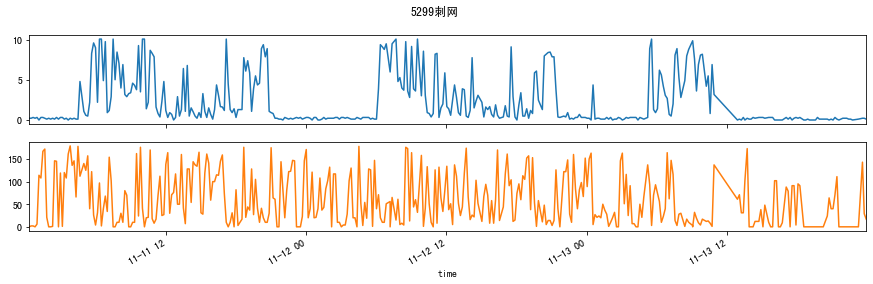

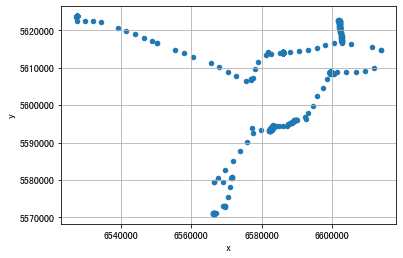

In [146]:
plot_vec_dir(df_train, 5299)

### test_pred

In [40]:
t = pd.DataFrame(pred_test_online).T
t = t.mode(axis=1)
result = pd.DataFrame(test_label["渔船ID"])
result['pred'] = t[0]

id_test_y_gt_6400000 = test_label[test_label.y_max>6400000]['渔船ID'].to_list()
result[result.渔船ID.isin(id_test_y_gt_6400000)]['pred'] = '围网'

In [41]:
print(result.pred.value_counts(normalize=True))
print(result.shape)

拖网    0.5905
围网    0.2475
刺网    0.1620
Name: pred, dtype: float64
(2000, 2)


In [42]:
result.to_csv(r"result_0.csv", header=None, index=None)

# 特征重要性

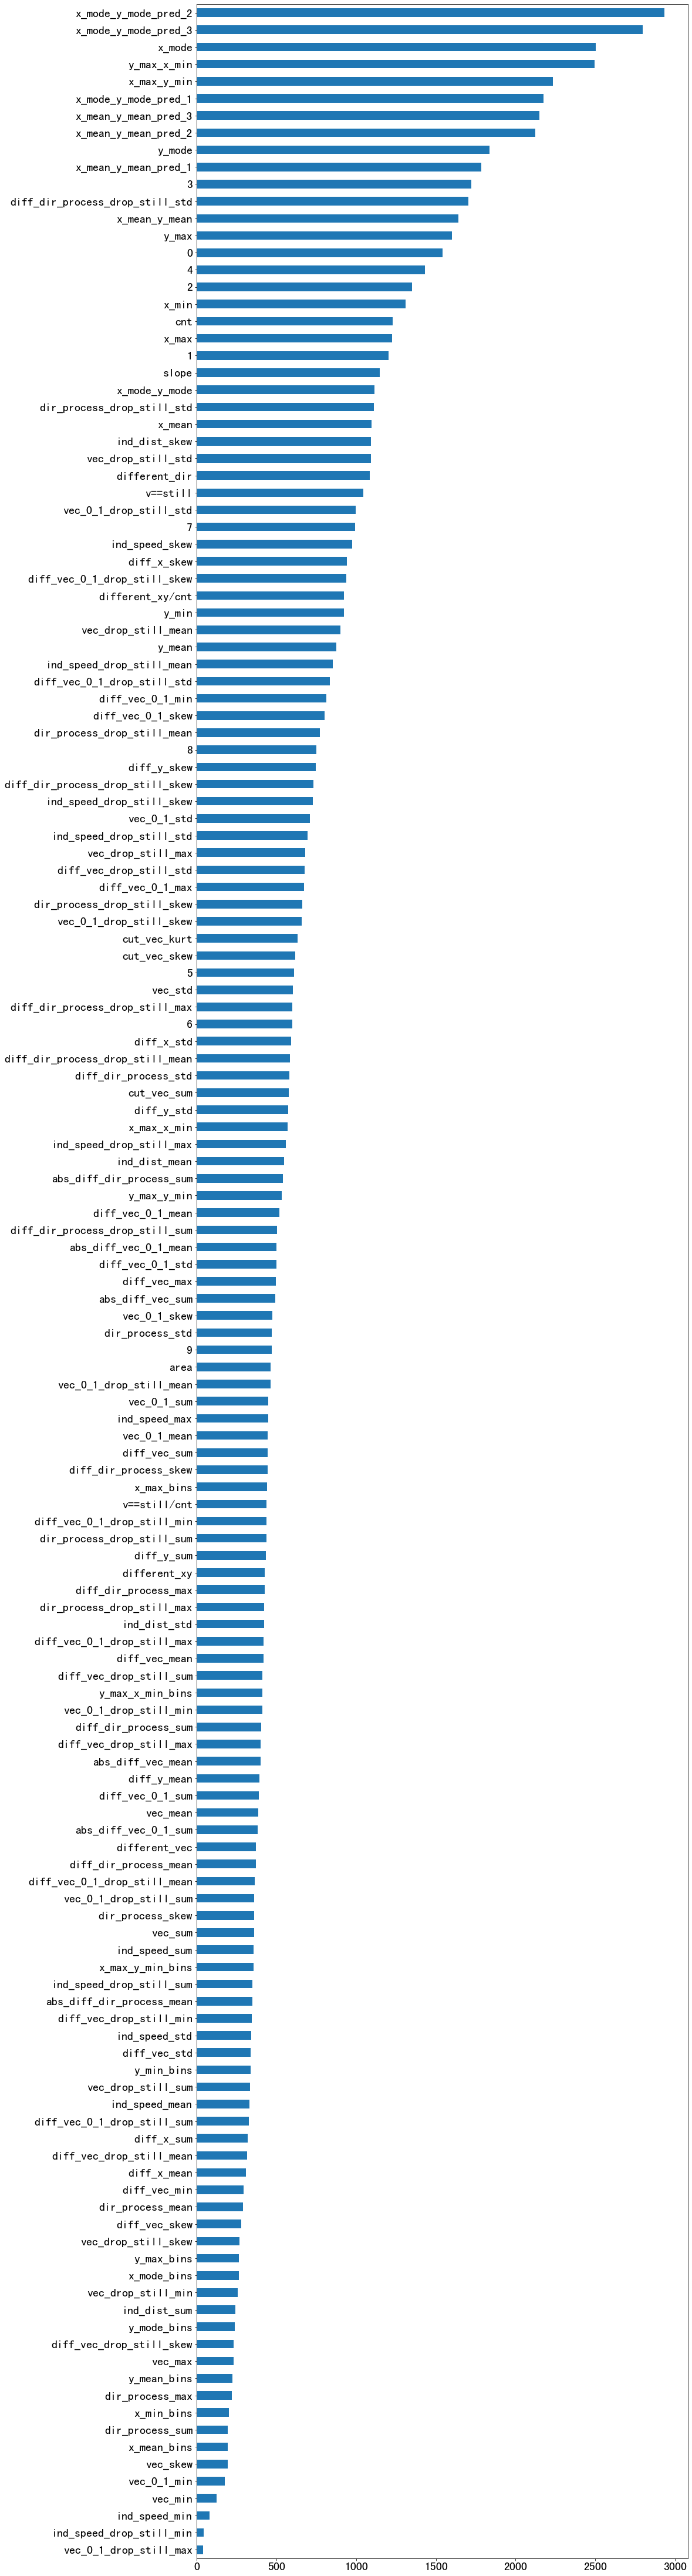

In [75]:
# fea_importances = pd.DataFrame(fea_importances.sort_values(ascending=False))
%matplotlib inline
features_sele = fea_importances.sort_values(ascending=False).index[:80]
fea_importances.sort_values().plot(kind='barh', figsize=(15,80), fontsize=20, )